In [ ]:
import numpy as np
import pandas as pd 
import anndata 
import sys
import matplotlib.pyplot as plt
import seaborn as sb
import mygene
import torch

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from utils import load_annotations
from torch.utils.data import Dataset, DataLoader
import argparse
from sklearn.linear_model import LogisticRegression
import time 

from datasets import RNASeqData
from models import pmVAEModel
from sklearn.preprocessing import OneHotEncoder

In [34]:
def get_sorted_means(ig, lr):
    ig['means'] = np.abs(ig).mean(1)
    lr['means'] = np.abs(lr).mean(1)
    
    sorted_ig = ig['means'].sort_values(ascending=False)
    sorted_lr = lr['means'].sort_values(ascending=False)
    
    return sorted_ig, sorted_lr

In [35]:
paths = np.loadtxt('compare_figs/mcfarland_paths.csv',delimiter=',', dtype='str')

In [36]:
len(paths)

170

In [37]:
path_names = list(paths) + ['AUXILIARY']

In [38]:
no_cond_ig = pd.read_csv('/homes/gws/aspiro17/pace_genome_bio/new_for_revision/new_res/mcfarland_new_dataset_no_cond_ctrl_ig.csv').set_axis(path_names)
no_cond_lr = pd.read_csv('/homes/gws/aspiro17/pace_genome_bio/new_for_revision/new_res/mcfarland_new_dataset_no_cond_ctrl_lr.csv').set_axis(path_names)

In [39]:
no_cond_ig, no_cond_lr = get_sorted_means(no_cond_ig, no_cond_lr)

In [47]:
cell_cond_ig = pd.read_csv('/homes/gws/aspiro17/pace_genome_bio/new_for_revision/new_res/mcfarland_cell_lines_cond_ig.csv').set_axis(path_names)
cell_cond_lr = pd.read_csv('/homes/gws/aspiro17/pace_genome_bio/new_for_revision/new_res/mcfarland_cell_lines_cond_lr.csv').set_axis(path_names)

In [48]:
cell_cond_ig, cell_cond_lr = get_sorted_means(cell_cond_ig, cell_cond_lr)

In [62]:
# get TSNE's of before vs after conditioning 

In [139]:
rand_seed=0
data  = anndata.read('/projects/leelab/data/single-cell/mcfarland_2020_Idasanutlin/preprocessed/adata_top_2000_genes_tc.h5ad')
data = data[data.obs['condition'] == 'Idasanutlin'].copy() 
symbols = data.var_names
train_data, test_data = train_test_split(data,
                                        test_size=0.25,
                                        shuffle=True,
                                        random_state=rand_seed)
tr_data, val_data = train_test_split(train_data,
                                    test_size=0.25,
                                    shuffle=True,
                                    random_state=rand_seed)

tr_ds = RNASeqData(np.array(tr_data.X))
val_ds = RNASeqData(np.array(val_data.X))
membership_mask = load_annotations('data/c2.cp.reactome.v7.4.symbols.gmt',
                                    symbols,
                                    min_genes=13
                                ).astype(bool).T

no_cond_checkpoint_path = '/homes/gws/aspiro17/pace_genome_bio/saved_models/new_dataset_no_cond_top_mcfarland_ctrl.pkl.best_loss'

no_cond_model = pmVAEModel(membership_mask.values,
                                [12],
                                1,
                                beta=1e-05,
                                terms=membership_mask.index,
                                add_auxiliary_module=True
                            )
no_cond_model.load_checkpoint(no_cond_checkpoint_path)
no_cond_model.set_gpu(False)

ground_truth = torch.tensor(np.array(data.X)).float()
outs = no_cond_model.model(ground_truth)

input_data = outs.z

tsne = TSNE(n_components=2,perplexity=40.0)
tsne = pd.DataFrame(
    TSNE().fit_transform(input_data.detach().numpy()),
    #index=latent_space.index,
    columns=['TSNE 1', 'TSNE 2'])

tsne['Cell line'] = np.array(data.obs['cell_line'])

/homes/gws/aspiro17/miniconda3/envs/fresh_anndata/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/homes/gws/aspiro17/miniconda3/envs/fresh_anndata/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/homes/gws/aspiro17/miniconda3/envs/fresh_anndata/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


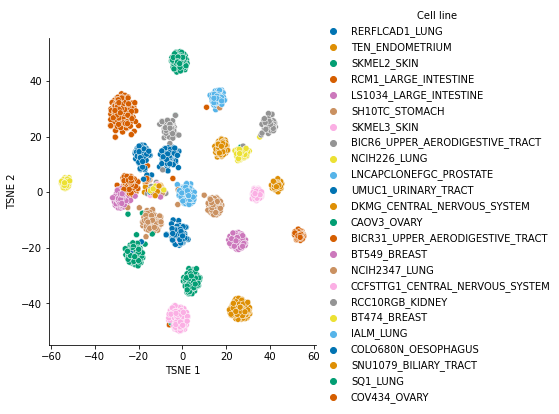

In [141]:
g = sb.relplot(data=tsne, x=tsne['TSNE 1'], y=tsne['TSNE 2'], hue=tsne['Cell line'], palette='colorblind')
g.savefig('new_for_revision/new_figs/Mcfarland_no_cond.pdf', bbox_inches='tight')

In [36]:
# with conditioning  

In [ ]:
conditions = np.array(data.obs['cell_line']).reshape(-1,1)
enc = OneHotEncoder()
enc.fit(conditions)
pre_processed_conditions = enc.transform(conditions).toarray()

cell_line_cond_checkpoint_path = 'saved_models/cond_mcfarland.pkl.best_loss'

cell_line_cond_model = pmVAEModel(membership_mask.values,
                                [12],
                                1,
                                beta=1e-05,
                                terms=membership_mask.index,
                                add_auxiliary_module=True
                            )
cell_line_cond_model.load_checkpoint(cell_line_cond_checkpoint_path)
cell_line_cond_model.set_gpu(False)
c_full = torch.tensor(pre_processed_conditions).float()
ground_truth = torch.tensor(np.array(data.X)).float()
outs = cell_line_cond_model.model(ground_truth, c_full)
input_data = outs.z
tsne = TSNE(n_components=2,perplexity=40.0)
tsne = pd.DataFrame(
    TSNE().fit_transform(input_data.detach().numpy()),
    #index=latent_space.index,
    columns=['TSNE 1', 'TSNE 2'])

tsne['Cell line'] = np.array(data.obs['cell_line'])

/homes/gws/aspiro17/miniconda3/envs/fresh_anndata/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/homes/gws/aspiro17/miniconda3/envs/fresh_anndata/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


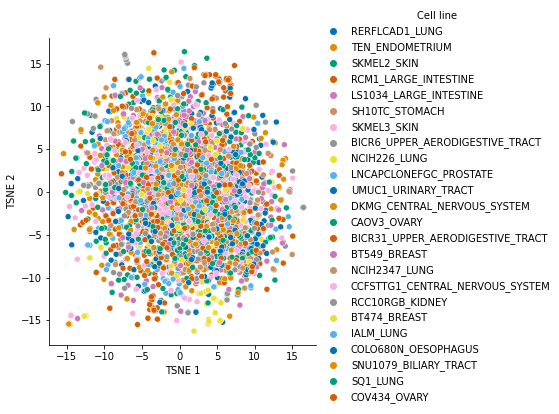

In [143]:
g = sb.relplot(data=tsne, x=tsne['TSNE 1'], y=tsne['TSNE 2'], hue=tsne['Cell line'], palette='colorblind')
leg = g._legend
g.savefig('new_for_revision/new_figs/Mcfarland_cond.pdf', bbox_inches='tight')

In [ ]:
dataset = pd.read_csv('/homes/gws/aspiro17/pace_genome_bio/new_for_revision/new_res/mcfarland_no_cond_ig.csv').set_axis(path_names).iloc[:170,:]

dataset['means'] = np.abs(dataset.iloc[:,:10]).mean(1)
dataset['stds'] = np.abs(dataset.iloc[:,:10]).std(1)
dataset = dataset.sort_values('means',ascending=False)
dataset['index'] = dataset.index

In [ ]:
new_dataset = dataset.rename(index={'REACTOME_REGULATION_OF_INSULIN_LIKE_GROWTH_FACTOR_IGF_TRANSPORT_AND_UPTAKE_BY_INSULIN_LIKE_GROWTH_FACTOR_BINDING_PROTEINS_IGFBPS':'REACTOME_REGULATION_OF_INSULIN_LIKE_GROWTH_FACTOR'})

In [230]:
# plot 
def make_top_paths_plot(dataset, title, save_title, number_top):
    means = list(dataset['means'])[:number_top]
    stds = list(dataset['stds'])[:number_top]
    
    bars = np.arange(len(means))
    labels = list(dataset['index'])[:number_top]

    fig, ax = plt.subplots(figsize=(6,6))
    ax.barh(bars, means, xerr=stds, align='center', alpha=0.5, ecolor='black')


    ax.set_yticks(bars)
    ax.set_yticklabels(labels)
    
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Mean Absolute Pathway Attribution')
    #plt.tight_layout()

    plt.title(title)
    plt.savefig('/homes/gws/aspiro17/pace_genome_bio/new_for_revision/new_figs/' + save_title +'.pdf', bbox_inches='tight')

    plt.show()

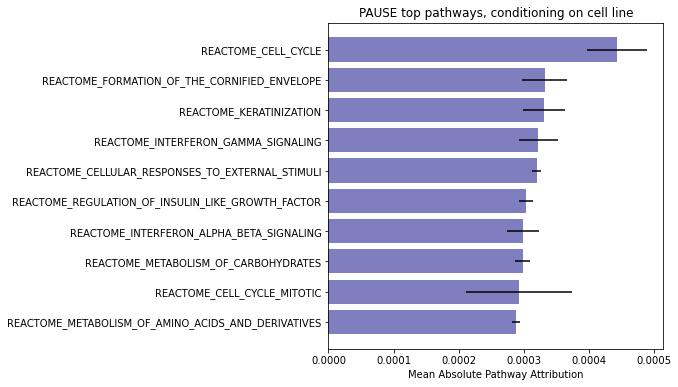

In [219]:
make_top_paths_plot(dataset, title='PAUSE top pathways, conditioning on cell line',save_title='mcfarland_cond_paths', number_top=10)

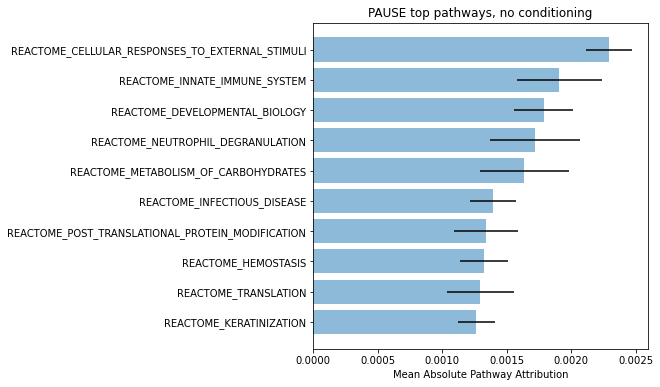

In [232]:
make_top_paths_plot(dataset, title='PAUSE top pathways, no conditioning',save_title='mcfarland_no_cond_paths', number_top=10)

In [220]:
dataset = pd.read_csv('/homes/gws/aspiro17/pace_genome_bio/new_for_revision/new_res/mcfarland_no_cond_lr.csv').set_axis(path_names)
dataset['means'] = np.abs(dataset.iloc[:,:10]).mean(1)
dataset['stds'] = np.abs(dataset.iloc[:,:10]).std(1)
dataset = dataset.sort_values('means',ascending=False)
dataset['index'] = dataset.index

In [221]:
dataset[:11]

,0,1,2,3,4,5,6,7,8,9,means,stds,index
REACTOME_PI3K_AKT_SIGNALING_IN_CANCER,-0.879518,-0.886403,-0.826162,-0.932874,-0.913941,-0.898451,-0.895009,-0.819277,-0.886403,-0.889845,0.882788,0.035278,REACTOME_PI3K_AKT_SIGNALING_IN_CANCER
REACTOME_RNA_POLYMERASE_II_TRANSCRIPTION,-0.865749,-0.896730,-0.908778,-0.870912,-0.891566,-0.810671,-0.872633,-0.867470,-0.901893,-0.774527,0.866093,0.042446,REACTOME_RNA_POLYMERASE_II_TRANSCRIPTION
REACTOME_PHASE_I_FUNCTIONALIZATION_OF_COMPOUNDS,-0.793460,-0.831325,-0.905336,-0.843373,-0.901893,-0.826162,-0.860585,-0.839931,-0.876076,-0.877797,0.855594,0.035380,REACTOME_PHASE_I_FUNCTIONALIZATION_OF_COMPOUNDS
REACTOME_TRANSCRIPTIONAL_REGULATION_BY_TP53,-0.759036,-0.810671,-0.846816,-0.802065,-0.888124,-0.853701,-0.846816,-0.860585,-0.757315,-0.893287,0.831842,0.048173,REACTOME_TRANSCRIPTIONAL_REGULATION_BY_TP53
REACTOME_DISEASES_OF_METABOLISM,-0.884682,-0.848537,-0.826162,-0.874355,-0.790017,-0.836489,-0.812392,-0.870912,-0.769363,-0.765921,0.827883,0.043048,REACTOME_DISEASES_OF_METABOLISM
REACTOME_THE_ROLE_OF_GTSE1_IN_G2_M_PROGRESSION_AFTER_G2_CHECKPOINT,-0.862306,-0.784854,-0.931153,-0.802065,-0.790017,-0.807229,-0.851979,-0.798623,-0.752151,-0.881239,0.826162,0.053973,REACTOME_THE_ROLE_OF_GTSE1_IN_G2_M_PROGRESSION...
REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES,-0.759036,-0.865749,-0.889845,-0.891566,-0.836489,-0.769363,-0.803787,-0.805508,-0.750430,-0.858864,0.823064,0.053098,REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES
REACTOME_INFLUENZA_INFECTION,-0.760757,-0.862306,-0.838210,-0.886403,-0.834768,-0.815835,-0.869191,-0.802065,-0.752151,-0.774527,0.819621,0.046770,REACTOME_INFLUENZA_INFECTION
REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION,-0.759036,-0.819277,-0.860585,-0.802065,-0.819277,-0.817556,-0.817556,-0.836489,-0.803787,-0.795181,0.813081,0.026605,REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION
REACTOME_RHO_GTPASE_EFFECTORS,-0.790017,-0.812392,-0.851979,-0.827883,-0.822719,-0.795181,-0.834768,-0.820998,-0.790017,-0.765921,0.811188,0.025671,REACTOME_RHO_GTPASE_EFFECTORS


In [222]:
# for LR res 

# plot 
def make_top_paths_plot(dataset, title, save_title, number_top):
    means = list(dataset['means'])[:number_top]
    stds = list(dataset['stds'])[:number_top]
    
    bars = np.arange(len(means))
    labels = list(dataset['index'])[:number_top]
    #labels = l # shorter name

    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(6,6))

    ax.barh(bars, means, xerr=stds, align='center', alpha=0.5, ecolor='black', color='darkgoldenrod')

    ax.set_yticks(bars)
    ax.set_yticklabels(labels)
    
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Mean Absolute Pathway Attribution')
    #plt.tight_layout()

    plt.title(title)
    
    plt.savefig('/homes/gws/aspiro17/pace_genome_bio/new_for_revision/new_figs/' + save_title +'.pdf', bbox_inches='tight')

    plt.show()


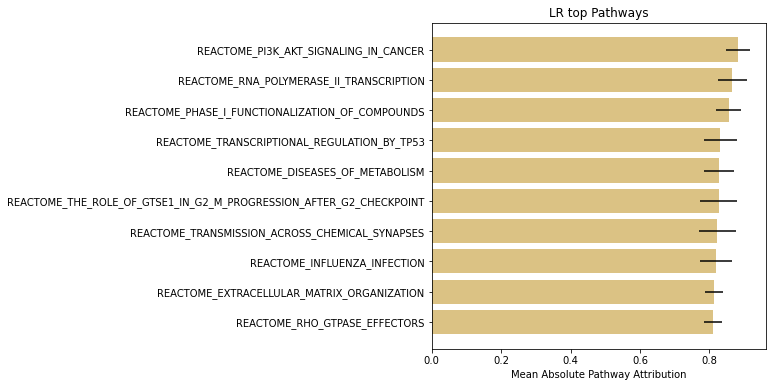

In [223]:
make_top_paths_plot(dataset, title='LR top Pathways',save_title='mcfarland_LR', number_top=10)

In [ ]:
# get cell line distribution plot 

In [ ]:
cell_line_vals = list(data.obs['cell_line'].values)
len(cell_line_vals)

unique_cell_lines = list(set(list(data.obs['cell_line'].values)))
unique_cell_lines

combined_cell_lines = ['LS1034_LARGE_INTESTINE',
 'SH10TC_STOMACH',
 'NCIH226_LUNG',
 'CAOV3_OVARY',
 'COLO680N_OESOPHAGUS',
 'SKMEL2_SKIN',
 'RCC10RGB_KIDNEY',
 'DKMG_CENTRAL_NERVOUS_SYSTEM',
 'UMUC1_URINARY_TRACT',
 'BT474_BREAST']